# IPCA Monte Carlo Simulation Study

## Replicating Section 7 of Kelly, Pruitt, Su (2020)

This notebook demonstrates the IPCA (Instrumented Principal Component Analysis) methodology using simulated data, following the Monte Carlo design in Section 7 of the paper.

**Objectives:**
1. Generate synthetic panel data following the IPCA model
2. Estimate the model and recover the true parameters
3. Run Monte Carlo simulations to verify asymptotic properties
4. Create visualizations similar to those in the paper

In [1]:
# Imports
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import linalg
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Local imports
from ipca import ipca
from simulate_ipca_data import (
    generate_ipca_data,
    compute_gamma_error,
    run_single_simulation
)

print("All imports successful!")

All imports successful!


---
## 1. Understanding the IPCA Model

The IPCA model is:

$$x_{i,t} = \beta_{i,t}' f_t + \varepsilon_{i,t}$$

$$\beta_{i,t} = \Gamma' c_{i,t}$$

Where:
- $x_{i,t}$: outcome (e.g., stock return)
- $f_t$: K latent factors
- $\beta_{i,t}$: time-varying factor loadings
- $c_{i,t}$: L observable characteristics
- $\Gamma$: L×K mapping matrix (key object to estimate)

---
## 2. Generate Synthetic Data

Following the paper's specification:
- N = 200 entities
- T = 200 time periods
- K = 2 factors
- L = 10 characteristics
- Target R² = 20%

In [2]:
# Simulation parameters (matching Section 7)
N = 200  # entities
T = 200  # time periods
K = 2    # factors
L = 10   # characteristics
TARGET_R2 = 0.20
SEED = 42

# Generate data
np.random.seed(SEED)
data = generate_ipca_data(
    N=N, T=T, K=K, L=L,
    target_r2=TARGET_R2,
    seed=SEED
)

print("=" * 60)
print("SYNTHETIC DATA GENERATED")
print("=" * 60)
print(f"Outcomes X shape: {data['X'].shape}")
print(f"Factors shape: {data['factors'].shape}")
print(f"Characteristics shape: {data['characteristics'].shape}")
print(f"True Gamma shape: {data['Gamma'].shape}")
print(f"DataFrame shape: {data['df'].shape}")
print(f"\nTarget R²: {TARGET_R2:.1%}")
print(f"Calibrated error std: {data['params']['error_std']:.4f}")

# Verify actual R²
signal = data['X'] - data['errors']
actual_r2 = np.var(signal) / np.var(data['X'])
print(f"Actual R²: {actual_r2:.1%}")

SYNTHETIC DATA GENERATED
Outcomes X shape: (200, 200)
Factors shape: (200, 2)
Characteristics shape: (200, 200, 10)
True Gamma shape: (10, 2)
DataFrame shape: (40000, 11)

Target R²: 20.0%
Calibrated error std: 28.7333
Actual R²: 19.9%


In [3]:
# Display true Gamma matrix
print("\nTrue Gamma Matrix (L×K):")
print("-" * 40)
Gamma_true = data['Gamma']
gamma_df = pd.DataFrame(
    Gamma_true,
    index=[f'Char_{i+1}' for i in range(L)],
    columns=[f'Factor_{k+1}' for k in range(K)]
)
print(gamma_df.round(4))


True Gamma Matrix (L×K):
----------------------------------------
         Factor_1  Factor_2
Char_1     0.2484   -0.0691
Char_2     0.3238    0.7615
Char_3    -0.1171   -0.1171
Char_4     0.7896    0.3837
Char_5    -0.2347    0.2713
Char_6    -0.2317   -0.2329
Char_7     0.1210   -0.9566
Char_8    -0.8625   -0.2811
Char_9    -0.5064    0.1571
Char_10   -0.4540   -0.7062


---
## 3. Visualize the Generated Data

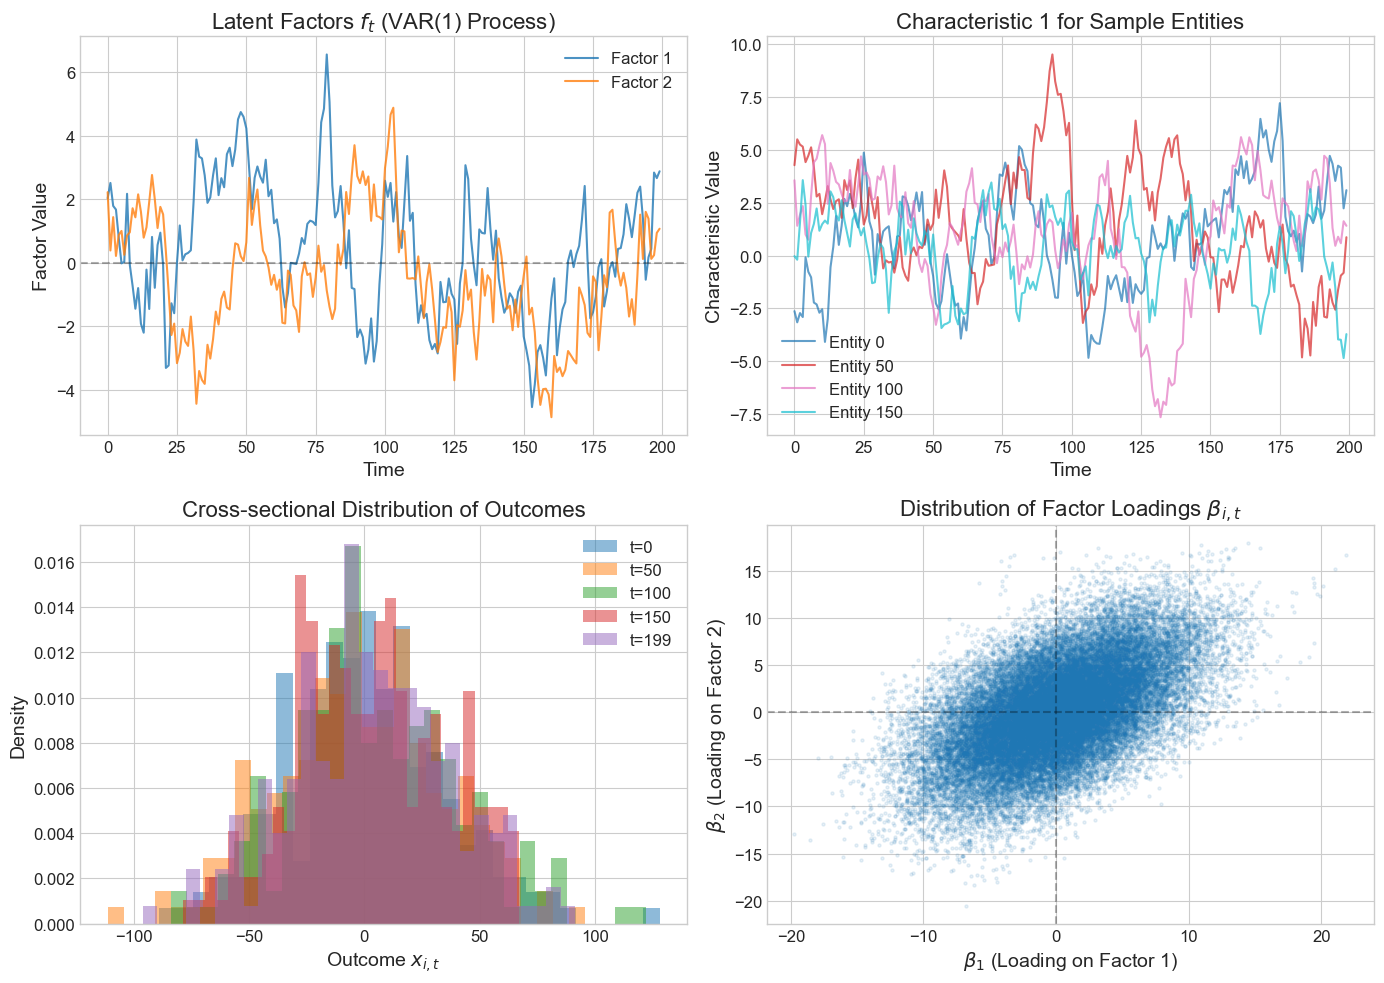

Saved: results/fig1_simulated_data_overview.png


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Latent Factors over time
ax1 = axes[0, 0]
for k in range(K):
    ax1.plot(data['factors'][:, k], label=f'Factor {k+1}', alpha=0.8)
ax1.set_xlabel('Time')
ax1.set_ylabel('Factor Value')
ax1.set_title('Latent Factors $f_t$ (VAR(1) Process)')
ax1.legend()
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 2: Sample characteristics for a few entities
ax2 = axes[0, 1]
sample_entities = [0, 50, 100, 150]
colors = plt.cm.tab10(np.linspace(0, 1, len(sample_entities)))
for idx, i in enumerate(sample_entities):
    ax2.plot(data['characteristics'][i, :, 0], 
             label=f'Entity {i}', color=colors[idx], alpha=0.7)
ax2.set_xlabel('Time')
ax2.set_ylabel('Characteristic Value')
ax2.set_title('Characteristic 1 for Sample Entities')
ax2.legend()

# Plot 3: Cross-sectional distribution of outcomes at different times
ax3 = axes[1, 0]
sample_times = [0, 50, 100, 150, 199]
for t in sample_times:
    ax3.hist(data['X'][:, t], bins=30, alpha=0.5, label=f't={t}', density=True)
ax3.set_xlabel('Outcome $x_{i,t}$')
ax3.set_ylabel('Density')
ax3.set_title('Cross-sectional Distribution of Outcomes')
ax3.legend()

# Plot 4: Factor loadings distribution
ax4 = axes[1, 1]
betas_flat = data['betas'].reshape(-1, K)
ax4.scatter(betas_flat[:, 0], betas_flat[:, 1], alpha=0.1, s=5)
ax4.set_xlabel('$\\beta_1$ (Loading on Factor 1)')
ax4.set_ylabel('$\\beta_2$ (Loading on Factor 2)')
ax4.set_title('Distribution of Factor Loadings $\\beta_{i,t}$')
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig1_simulated_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig1_simulated_data_overview.png")

---
## 4. Estimate IPCA Model

Now we fit the IPCA model to recover the latent factors and the Gamma matrix.

In [5]:
# Prepare data for IPCA
df_ipca = data['df'].copy()
print(f"Input DataFrame shape: {df_ipca.shape}")
print(f"\nFirst few rows:")
print(df_ipca.head())

Input DataFrame shape: (40000, 11)

First few rows:
                  outcome    char_1    char_2    char_3    char_4    char_5  \
date    entity                                                                
2000-01 0      -68.960821 -2.630445 -8.868931 -7.491931 -4.055227  3.610824   
        1       36.179004 -3.769144 -2.431442 -4.783820 -1.117067  1.283435   
        2       62.675066  3.189245 -3.146032 -3.402414  2.006045 -2.249725   
        3        1.856881 -2.013478 -0.332246  2.881340  1.191843  5.688616   
        4       -2.686512  3.688776 -3.351130  4.400679 -2.512322  4.332967   

                  char_6    char_7    char_8    char_9   char_10  
date    entity                                                    
2000-01 0      -0.471359  2.856320 -7.000764  0.395682 -0.140276  
        1       1.729350 -2.842865 -0.603249 -2.408368 -0.078843  
        2       1.276778 -0.037329 -1.749887 -2.855798 -2.407921  
        3       2.743539  4.417501  3.570647 -6.068608  3.3

In [6]:
# Fit IPCA model
print("Fitting IPCA model...")
print("=" * 60)

model = ipca(RZ=df_ipca, return_column='outcome', add_constant=False)

results = model.fit(
    K=K,
    OOS=False,
    R_fit=True,
    dispIters=True,
    dispItersInt=100,
    maxIters=2000,
    minTol=1e-5
)

print("\nEstimation complete!")

Fitting IPCA model...
ipca.fit finished estimation after 0 seconds and 7 iterations

Estimation complete!


In [7]:
# Extract estimated Gamma
Gamma_hat = results['Gamma'].values

print("\nEstimated Gamma Matrix:")
print("-" * 40)
print(results['Gamma'].round(4))

# Report R² if available
if 'rfits' in results and results['rfits'] is not None:
    rfits = results['rfits']
    print(f"\nModel Fit:")
    if 'R2_Total' in rfits:
        print(f"  Total R²: {rfits['R2_Total']*100:.2f}%")
    if 'R2_Pred' in rfits:
        print(f"  Predictive R²: {rfits['R2_Pred']*100:.2f}%")


Estimated Gamma Matrix:
----------------------------------------
              0       1
char_1  -0.1106  0.2162
char_2  -0.4254 -0.2923
char_3   0.0943 -0.0250
char_4  -0.4793  0.2679
char_5   0.0220 -0.2955
char_6   0.1992 -0.0039
char_7   0.2939  0.6473
char_8   0.4619 -0.3349
char_9   0.1681 -0.3921
char_10  0.4471  0.1520

Model Fit:
  Total R²: 20.87%
  Predictive R²: 0.40%


---
## 5. Compare Estimated vs True Parameters

Since IPCA identifies $\Gamma$ only up to rotation, we use Procrustes alignment.

In [8]:
# Align estimated Gamma to true Gamma using Procrustes
error_info = compute_gamma_error(Gamma_true, Gamma_hat)

print("Gamma Estimation Error Analysis")
print("=" * 60)
print(f"Frobenius norm ||Gamma_true - Gamma_hat_aligned||: {error_info['frobenius_error']:.4f}")
print(f"RMSE: {error_info['rmse']:.4f}")

# Display aligned estimate
Gamma_hat_aligned = error_info['Gamma_hat_rotated']
print("\nTrue Gamma:")
print(Gamma_true.round(4))
print("\nEstimated Gamma (after rotation alignment):")
print(Gamma_hat_aligned.round(4))
print("\nDifference (True - Estimated):")
print((Gamma_true - Gamma_hat_aligned).round(4))

Gamma Estimation Error Analysis
Frobenius norm ||Gamma_true - Gamma_hat_aligned||: 0.8025
RMSE: 0.1794

True Gamma:
[[ 0.2484 -0.0691]
 [ 0.3238  0.7615]
 [-0.1171 -0.1171]
 [ 0.7896  0.3837]
 [-0.2347  0.2713]
 [-0.2317 -0.2329]
 [ 0.121  -0.9566]
 [-0.8625 -0.2811]
 [-0.5064  0.1571]
 [-0.454  -0.7062]]

Estimated Gamma (after rotation alignment):
[[ 0.2278 -0.084 ]
 [ 0.1147  0.5032]
 [-0.0863 -0.0455]
 [ 0.534   0.1278]
 [-0.2165  0.2024]
 [-0.1492 -0.1322]
 [ 0.2225 -0.6752]
 [-0.5666 -0.0667]
 [-0.3894  0.1744]
 [-0.2258 -0.4148]]

Difference (True - Estimated):
[[ 0.0205  0.0149]
 [ 0.2091  0.2583]
 [-0.0307 -0.0715]
 [ 0.2556  0.2559]
 [-0.0183  0.0689]
 [-0.0826 -0.1007]
 [-0.1015 -0.2814]
 [-0.2958 -0.2144]
 [-0.117  -0.0173]
 [-0.2282 -0.2913]]


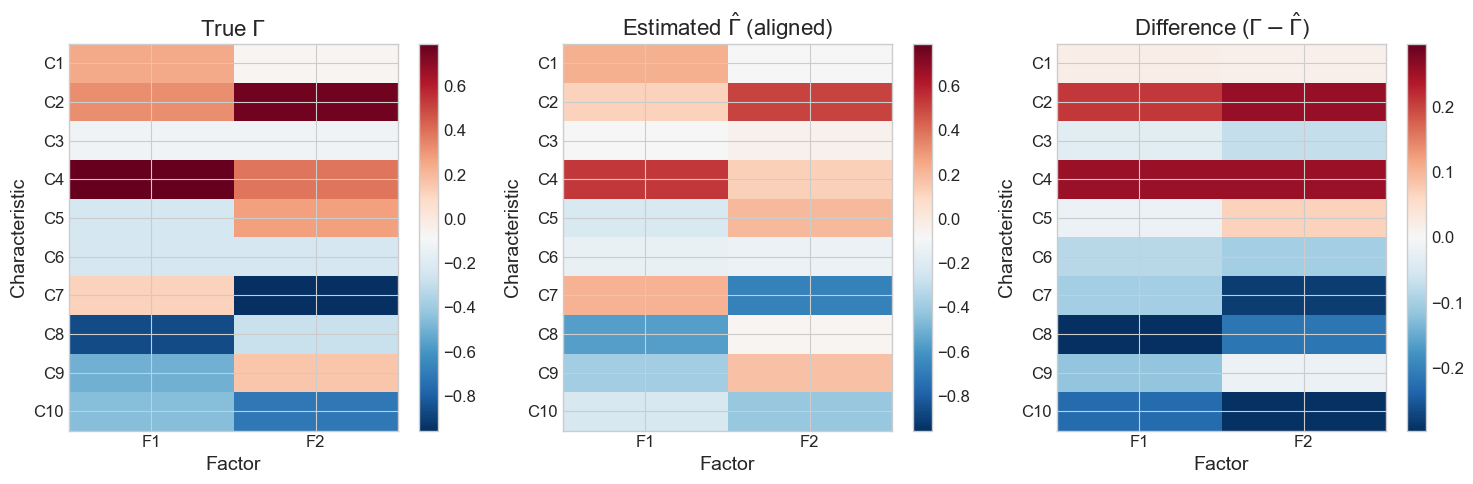

Saved: results/fig2_gamma_comparison.png


In [9]:
# Visualization: True vs Estimated Gamma
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

vmin = min(Gamma_true.min(), Gamma_hat_aligned.min())
vmax = max(Gamma_true.max(), Gamma_hat_aligned.max())

# True Gamma
im1 = axes[0].imshow(Gamma_true, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_title('True $\\Gamma$')
axes[0].set_xlabel('Factor')
axes[0].set_ylabel('Characteristic')
axes[0].set_xticks(range(K))
axes[0].set_xticklabels([f'F{k+1}' for k in range(K)])
axes[0].set_yticks(range(L))
axes[0].set_yticklabels([f'C{l+1}' for l in range(L)])
plt.colorbar(im1, ax=axes[0])

# Estimated Gamma (aligned)
im2 = axes[1].imshow(Gamma_hat_aligned, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_title('Estimated $\\hat{\\Gamma}$ (aligned)')
axes[1].set_xlabel('Factor')
axes[1].set_ylabel('Characteristic')
axes[1].set_xticks(range(K))
axes[1].set_xticklabels([f'F{k+1}' for k in range(K)])
axes[1].set_yticks(range(L))
axes[1].set_yticklabels([f'C{l+1}' for l in range(L)])
plt.colorbar(im2, ax=axes[1])

# Difference
diff = Gamma_true - Gamma_hat_aligned
vabs = max(abs(diff.min()), abs(diff.max()))
im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vabs, vmax=vabs)
axes[2].set_title('Difference ($\\Gamma - \\hat{\\Gamma}$)')
axes[2].set_xlabel('Factor')
axes[2].set_ylabel('Characteristic')
axes[2].set_xticks(range(K))
axes[2].set_xticklabels([f'F{k+1}' for k in range(K)])
axes[2].set_yticks(range(L))
axes[2].set_yticklabels([f'C{l+1}' for l in range(L)])
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.savefig('results/fig2_gamma_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig2_gamma_comparison.png")

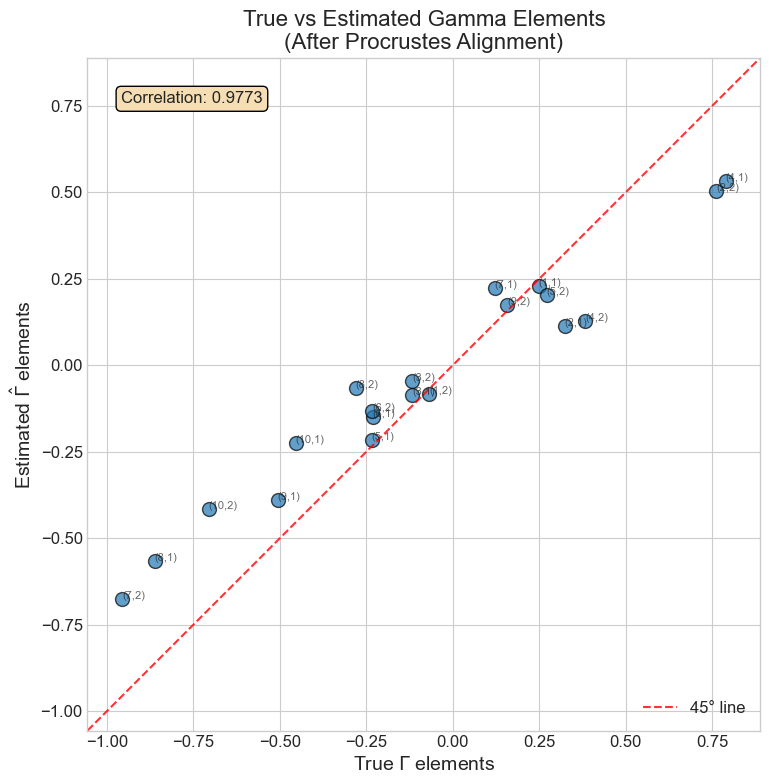

Saved: results/fig3_gamma_scatter.png


In [10]:
# Scatter plot: True vs Estimated Gamma elements
fig, ax = plt.subplots(figsize=(8, 8))

gamma_true_flat = Gamma_true.flatten()
gamma_hat_flat = Gamma_hat_aligned.flatten()

ax.scatter(gamma_true_flat, gamma_hat_flat, s=100, alpha=0.7, edgecolors='black')

# Add 45-degree line
lims = [min(gamma_true_flat.min(), gamma_hat_flat.min()) - 0.1,
        max(gamma_true_flat.max(), gamma_hat_flat.max()) + 0.1]
ax.plot(lims, lims, 'r--', alpha=0.8, label='45° line')

# Add labels for each point
for l in range(L):
    for k in range(K):
        idx = l * K + k
        ax.annotate(f'({l+1},{k+1})', 
                   (gamma_true_flat[idx], gamma_hat_flat[idx]),
                   fontsize=8, alpha=0.7)

ax.set_xlabel('True $\\Gamma$ elements')
ax.set_ylabel('Estimated $\\hat{\\Gamma}$ elements')
ax.set_title('True vs Estimated Gamma Elements\n(After Procrustes Alignment)')
ax.legend()
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

# Add correlation
corr = np.corrcoef(gamma_true_flat, gamma_hat_flat)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.savefig('results/fig3_gamma_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig3_gamma_scatter.png")

---
## 6. Compare Estimated vs True Factors

Estimated factors shape: (2, 196)
True factors shape: (200, 2)
Comparing 196 time periods


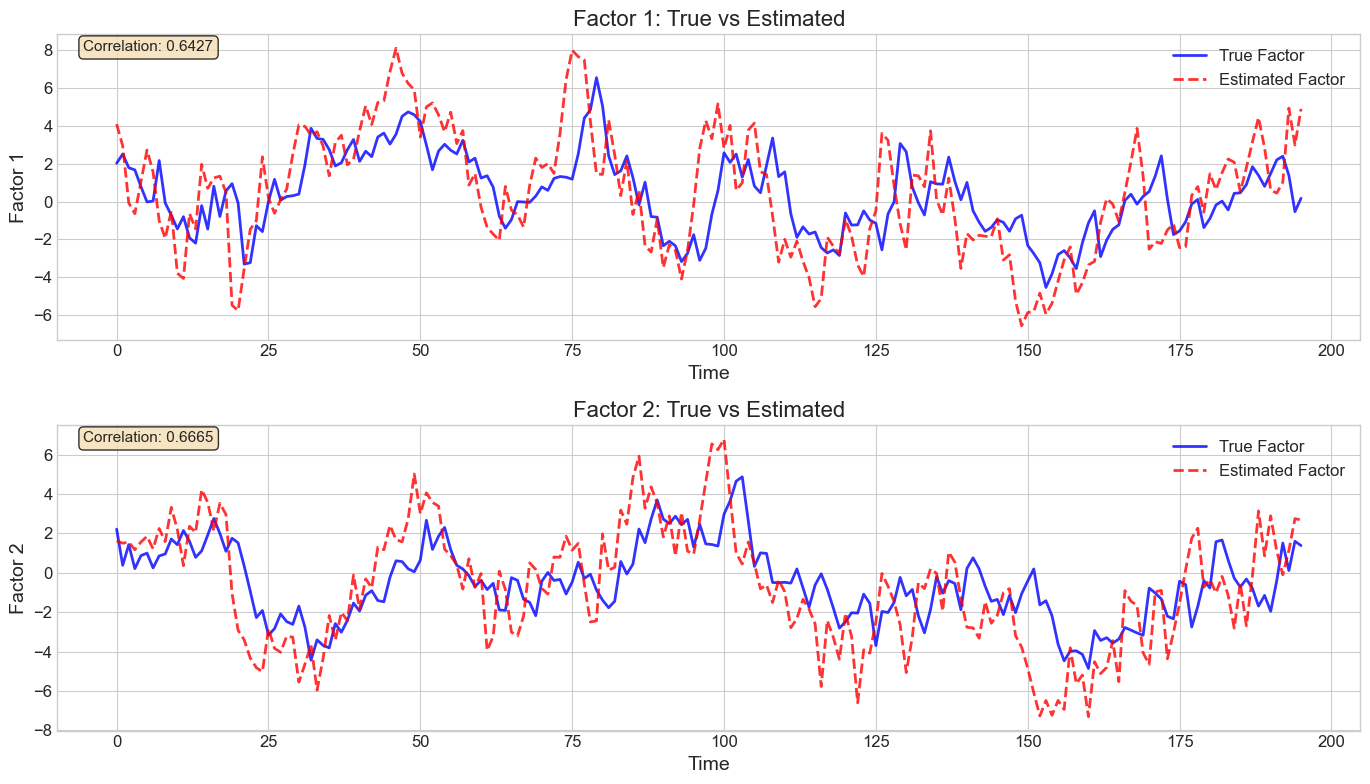

Saved: results/fig4_factors_comparison.png


In [11]:
# Extract estimated factors
if 'Factors' in results and results['Factors'] is not None:
    # IPCA returns factors as (K, T) DataFrame with dates as columns
    F_hat_df = results['Factors']
    print(f"Estimated factors shape: {F_hat_df.shape}")
    print(f"True factors shape: {data['factors'].shape}")
    
    # Get the number of time periods that match
    T_est = F_hat_df.shape[1]  # Number of estimated time periods
    T_true = data['factors'].shape[0]  # Number of simulated time periods
    T_common = min(T_est, T_true)
    
    # Transpose F_hat to (T, K) and take first T_common periods
    F_hat = F_hat_df.values.T[:T_common, :]  # (T_common, K)
    F_true = data['factors'][:T_common, :]   # (T_common, K)
    
    # Align factors using the same rotation matrix
    H = error_info['H']
    F_hat_aligned = F_hat @ linalg.inv(H).T
    
    print(f"Comparing {T_common} time periods")
    
    # Plot comparison
    fig, axes = plt.subplots(K, 1, figsize=(14, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        ax = axes[k]
        ax.plot(F_true[:, k], 'b-', label='True Factor', alpha=0.8, linewidth=2)
        ax.plot(F_hat_aligned[:, k], 'r--', label='Estimated Factor', alpha=0.8, linewidth=2)
        ax.set_xlabel('Time')
        ax.set_ylabel(f'Factor {k+1}')
        ax.set_title(f'Factor {k+1}: True vs Estimated')
        ax.legend()
        
        # Correlation
        corr = np.corrcoef(F_true[:, k], F_hat_aligned[:, k])[0, 1]
        ax.text(0.02, 0.98, f'Correlation: {corr:.4f}', transform=ax.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/fig4_factors_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: results/fig4_factors_comparison.png")
else:
    print("Factors not available in results")

---
## 7. Monte Carlo Simulation

Following Section 7 of the paper, we run multiple simulations to:
1. Verify that estimation errors are centered at zero
2. Check that the distribution matches asymptotic theory
3. Examine how errors scale with sample size

In [12]:
# Monte Carlo settings
N_SIMULATIONS = 50  # Use 200 for full replication (slower)
MC_N = 200
MC_T = 200
MC_K = 2
MC_L = 10
BASE_SEED = 1000

print(f"Running {N_SIMULATIONS} Monte Carlo simulations...")
print(f"Parameters: N={MC_N}, T={MC_T}, K={MC_K}, L={MC_L}")
print("This may take a few minutes...")
print("=" * 60)

Running 50 Monte Carlo simulations...
Parameters: N=200, T=200, K=2, L=10
This may take a few minutes...


In [13]:
# Run Monte Carlo
np.random.seed(BASE_SEED)
MC_Gamma_true = np.random.randn(MC_L, MC_K) * 0.5

all_errors = []
all_frobenius = []
all_rmse = []
successful_sims = 0

for sim in range(N_SIMULATIONS):
    if (sim + 1) % 10 == 0:
        print(f"  Simulation {sim + 1}/{N_SIMULATIONS}...")
    
    seed = BASE_SEED + sim + 1
    
    try:
        # Generate data
        sim_data = generate_ipca_data(
            N=MC_N, T=MC_T, K=MC_K, L=MC_L,
            Gamma=MC_Gamma_true,
            seed=seed
        )
        
        # Fit IPCA
        sim_model = ipca(RZ=sim_data['df'], return_column='outcome', add_constant=False)
        sim_results = sim_model.fit(
            K=MC_K,
            OOS=False,
            R_fit=False,
            dispIters=False,
            maxIters=2000,
            minTol=1e-5
        )
        
        # Compute errors
        Gamma_hat_sim = sim_results['Gamma'].values
        err_info = compute_gamma_error(MC_Gamma_true, Gamma_hat_sim)
        
        all_errors.append(err_info['elementwise_errors'])
        all_frobenius.append(err_info['frobenius_error'])
        all_rmse.append(err_info['rmse'])
        successful_sims += 1
        
    except Exception as e:
        print(f"    Simulation {sim + 1} failed: {str(e)[:50]}")
        continue

print("\n" + "=" * 60)
print(f"Completed: {successful_sims}/{N_SIMULATIONS} simulations")
print("=" * 60)

ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 8 iterations
ipca.fit finished estimation after 0 seconds and 8 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 8 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
  Simulation 10/50...
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 9 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and 9 iterations
ipca.fit finished estimation after 0 seconds and 8 iterations
ipca.fit finished estimation after 0 seconds and 7 iterations
ipca.fit finished estimation after 0 seconds and

In [14]:
# Convert to arrays
all_errors = np.array(all_errors)
all_frobenius = np.array(all_frobenius)
all_rmse = np.array(all_rmse)

print("Monte Carlo Summary Statistics")
print("=" * 60)
print(f"Mean Frobenius error: {np.mean(all_frobenius):.4f}")
print(f"Std Frobenius error: {np.std(all_frobenius):.4f}")
print(f"Mean RMSE: {np.mean(all_rmse):.4f}")
print(f"Std RMSE: {np.std(all_rmse):.4f}")
print(f"\nElementwise error mean: {np.mean(all_errors):.6f}")
print(f"Elementwise error std: {np.std(all_errors):.4f}")

Monte Carlo Summary Statistics
Mean Frobenius error: 0.3994
Std Frobenius error: 0.0027
Mean RMSE: 0.0893
Std RMSE: 0.0006

Elementwise error mean: 0.014988
Elementwise error std: 0.0880


---
## 8. Monte Carlo Results: Distribution of Estimation Errors

Following the paper's Figure 2, we plot the distribution of estimation errors and compare to the asymptotic normal distribution.

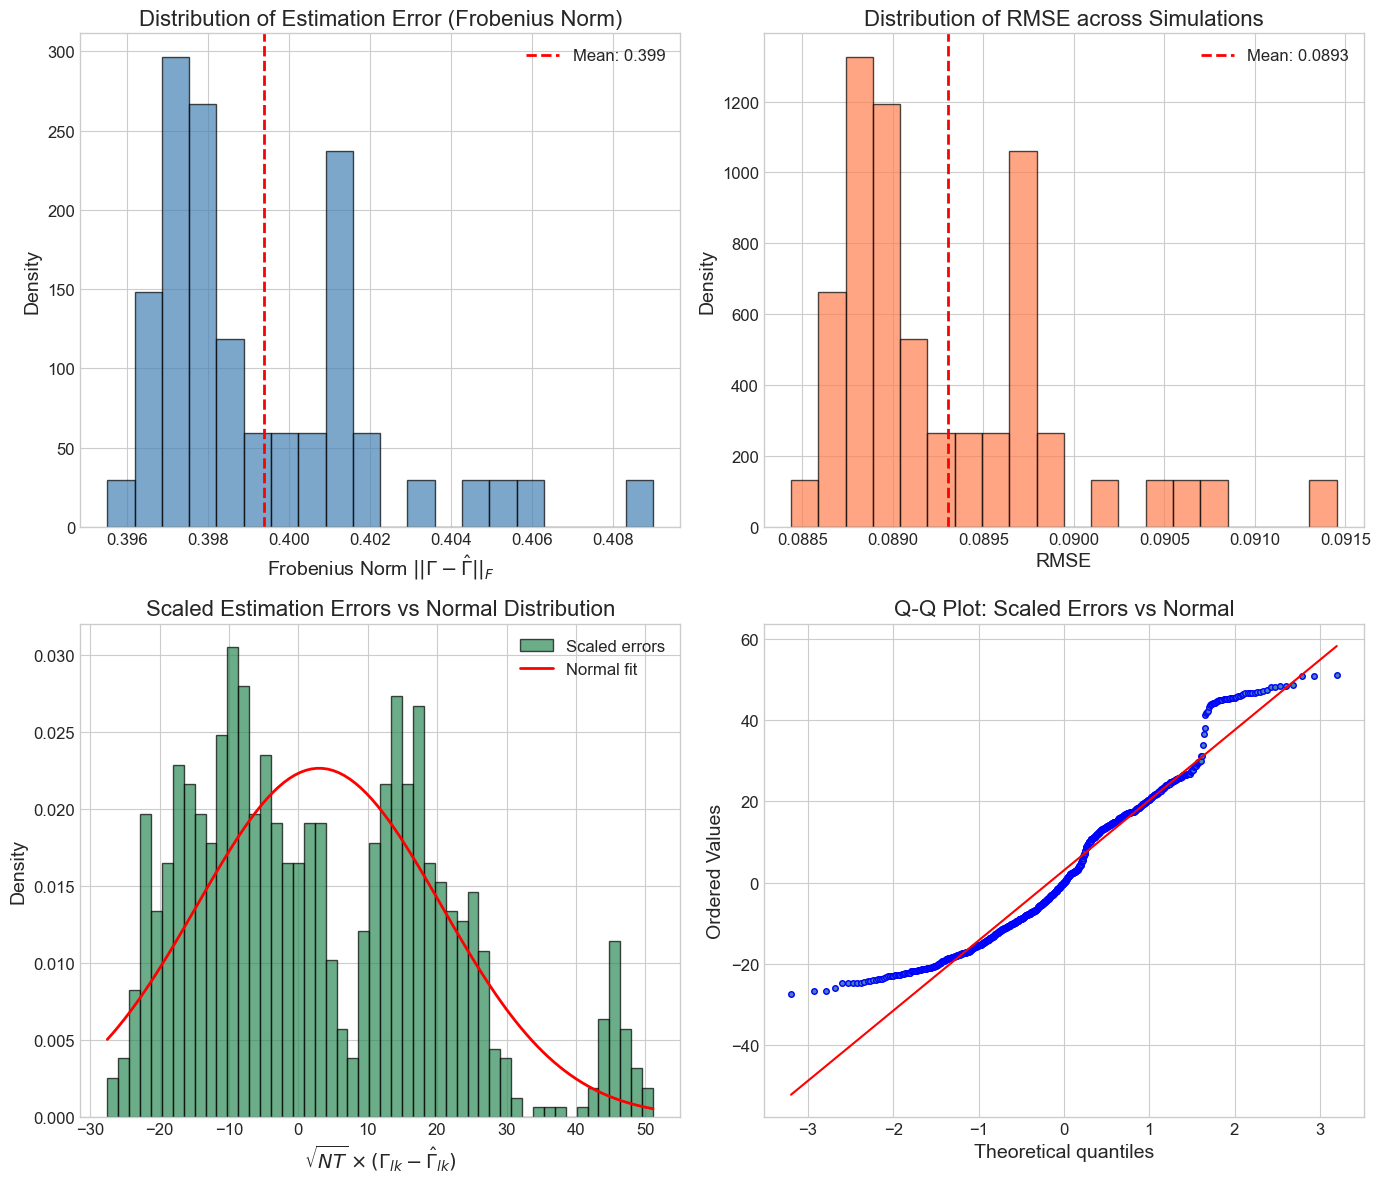

Saved: results/fig5_monte_carlo_errors.png


In [15]:
# Figure similar to paper's Figure 2: Distribution of estimation errors
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Distribution of Frobenius errors
ax1 = axes[0, 0]
ax1.hist(all_frobenius, bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(np.mean(all_frobenius), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_frobenius):.3f}')
ax1.set_xlabel('Frobenius Norm $||\\Gamma - \\hat{\\Gamma}||_F$')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Estimation Error (Frobenius Norm)')
ax1.legend()

# Plot 2: Distribution of RMSE
ax2 = axes[0, 1]
ax2.hist(all_rmse, bins=20, density=True, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(np.mean(all_rmse), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_rmse):.4f}')
ax2.set_xlabel('RMSE')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of RMSE across Simulations')
ax2.legend()

# Plot 3: Elementwise errors - histogram with normal overlay
ax3 = axes[1, 0]
errors_flat = all_errors.flatten()

# Scale by sqrt(NT) as in asymptotic theory
scaling = np.sqrt(MC_N * MC_T)
errors_scaled = errors_flat * scaling

ax3.hist(errors_scaled, bins=50, density=True, alpha=0.7, color='seagreen', edgecolor='black', label='Scaled errors')

# Overlay normal distribution
x_range = np.linspace(errors_scaled.min(), errors_scaled.max(), 100)
normal_pdf = stats.norm.pdf(x_range, loc=np.mean(errors_scaled), scale=np.std(errors_scaled))
ax3.plot(x_range, normal_pdf, 'r-', linewidth=2, label='Normal fit')

ax3.set_xlabel('$\\sqrt{NT} \\times (\\Gamma_{lk} - \\hat{\\Gamma}_{lk})$')
ax3.set_ylabel('Density')
ax3.set_title('Scaled Estimation Errors vs Normal Distribution')
ax3.legend()

# Plot 4: Q-Q plot
ax4 = axes[1, 1]
stats.probplot(errors_scaled, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Scaled Errors vs Normal')
ax4.get_lines()[0].set_markerfacecolor('steelblue')
ax4.get_lines()[0].set_markersize(4)

plt.tight_layout()
plt.savefig('results/fig5_monte_carlo_errors.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig5_monte_carlo_errors.png")

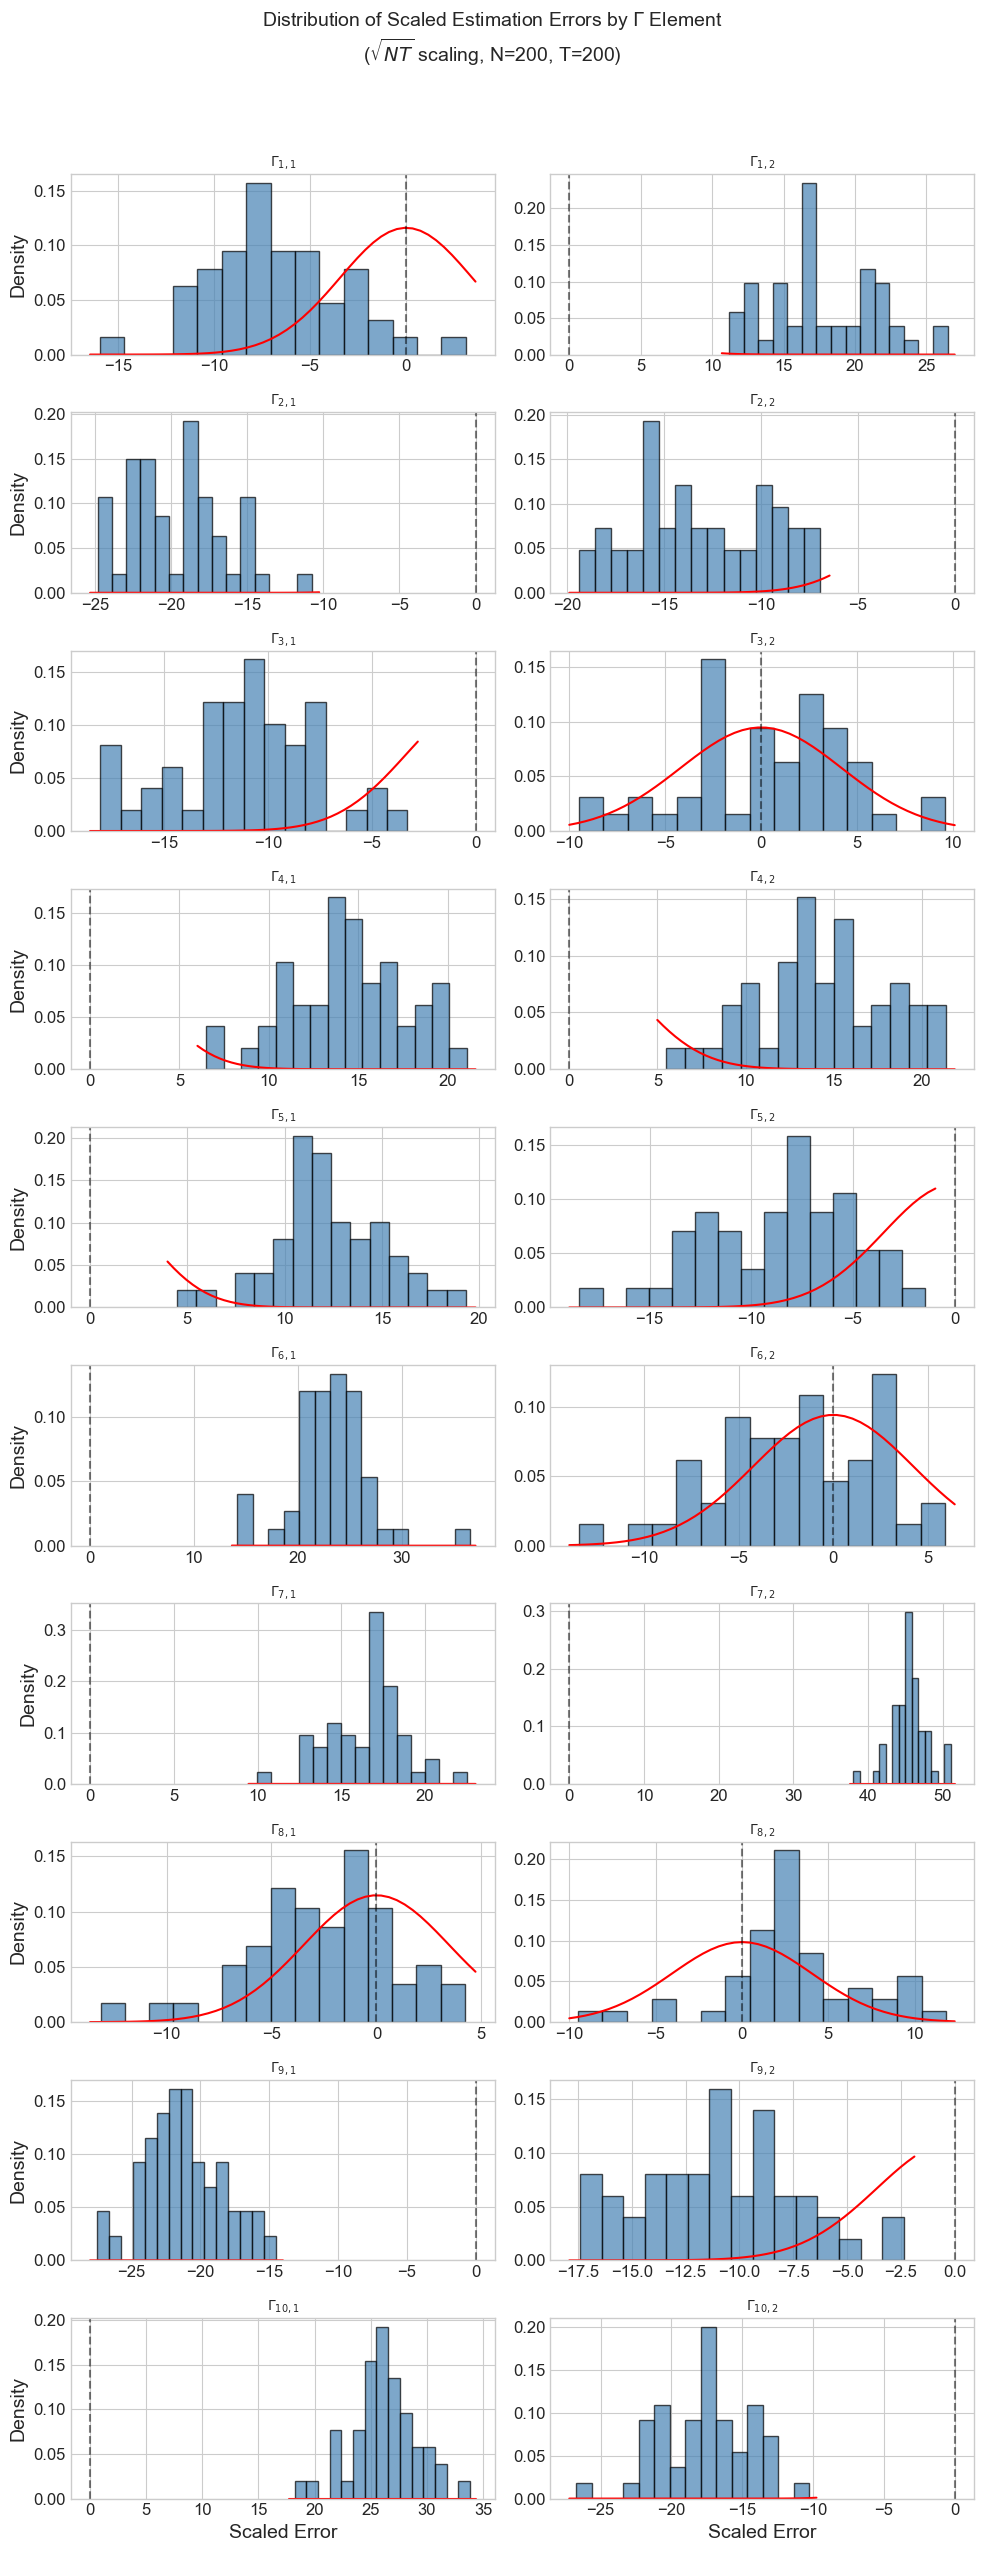

Saved: results/fig6_elementwise_errors.png


In [16]:
# Figure: Elementwise errors for each Gamma component
fig, axes = plt.subplots(MC_L, MC_K, figsize=(10, 2.5*MC_L))

for l in range(MC_L):
    for k in range(MC_K):
        ax = axes[l, k]
        idx = l * MC_K + k
        errors_lk = all_errors[:, idx]
        
        # Scale by sqrt(NT)
        errors_lk_scaled = errors_lk * scaling
        
        ax.hist(errors_lk_scaled, bins=15, density=True, alpha=0.7, 
                color='steelblue', edgecolor='black')
        
        # Normal overlay
        x_range = np.linspace(errors_lk_scaled.min() - 0.5, errors_lk_scaled.max() + 0.5, 50)
        normal_pdf = stats.norm.pdf(x_range, loc=0, scale=np.std(errors_lk_scaled))
        ax.plot(x_range, normal_pdf, 'r-', linewidth=1.5)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'$\\Gamma_{{{l+1},{k+1}}}$', fontsize=10)
        
        if l == MC_L - 1:
            ax.set_xlabel('Scaled Error')
        if k == 0:
            ax.set_ylabel('Density')

plt.suptitle('Distribution of Scaled Estimation Errors by $\\Gamma$ Element\n' + 
             f'($\\sqrt{{NT}}$ scaling, N={MC_N}, T={MC_T})', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('results/fig6_elementwise_errors.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig6_elementwise_errors.png")

---
## 9. Convergence Analysis: Error vs Sample Size

The asymptotic theory predicts that estimation errors decrease at rate $1/\sqrt{NT}$.

In [17]:
# Run simulations with different sample sizes
sample_sizes = [(50, 50), (100, 100), (150, 150), (200, 200)]
n_sims_per_size = 20

convergence_results = []

print("Running convergence analysis...")
print("=" * 60)

for N_size, T_size in sample_sizes:
    print(f"  N={N_size}, T={T_size}...")
    
    rmse_list = []
    
    for sim in range(n_sims_per_size):
        seed = 5000 + N_size * 100 + sim
        
        try:
            sim_data = generate_ipca_data(
                N=N_size, T=T_size, K=MC_K, L=MC_L,
                Gamma=MC_Gamma_true,
                seed=seed
            )
            
            sim_model = ipca(RZ=sim_data['df'], return_column='outcome', add_constant=False)
            sim_results = sim_model.fit(
                K=MC_K, OOS=False, R_fit=False,
                dispIters=False, maxIters=2000, minTol=1e-5
            )
            
            Gamma_hat_sim = sim_results['Gamma'].values
            err_info = compute_gamma_error(MC_Gamma_true, Gamma_hat_sim)
            rmse_list.append(err_info['rmse'])
            
        except:
            continue
    
    if rmse_list:
        convergence_results.append({
            'N': N_size,
            'T': T_size,
            'NT': N_size * T_size,
            'sqrt_NT': np.sqrt(N_size * T_size),
            'mean_rmse': np.mean(rmse_list),
            'std_rmse': np.std(rmse_list),
            'n_successful': len(rmse_list)
        })

conv_df = pd.DataFrame(convergence_results)
print("\nConvergence Results:")
print(conv_df)

Running convergence analysis...
  N=50, T=50...
ipca.fit finished estimation after 0 seconds and 78 iterations
ipca.fit finished estimation after 0 seconds and 13 iterations
ipca.fit finished estimation after 0 seconds and 13 iterations
ipca.fit finished estimation after 0 seconds and 20 iterations
ipca.fit finished estimation after 0 seconds and 12 iterations
ipca.fit finished estimation after 0 seconds and 17 iterations
ipca.fit finished estimation after 0 seconds and 17 iterations
ipca.fit finished estimation after 0 seconds and 21 iterations
ipca.fit finished estimation after 0 seconds and 103 iterations
ipca.fit finished estimation after 0 seconds and 57 iterations
ipca.fit finished estimation after 0 seconds and 11 iterations
ipca.fit finished estimation after 0 seconds and 20 iterations
ipca.fit finished estimation after 0 seconds and 23 iterations
ipca.fit finished estimation after 0 seconds and 67 iterations
ipca.fit finished estimation after 0 seconds and 13 iterations
ipca.f

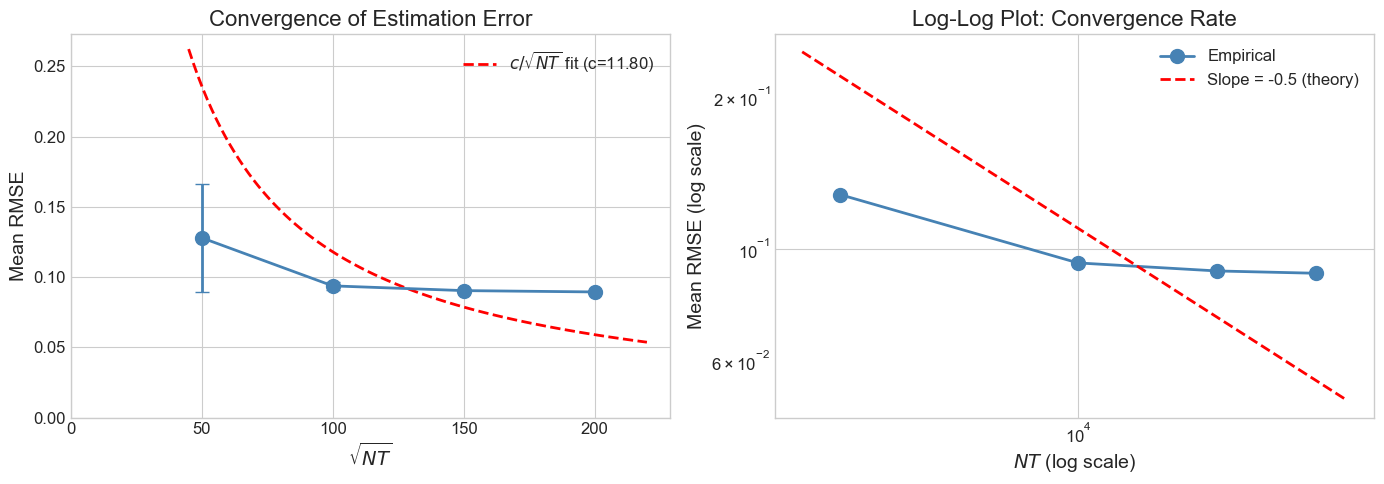

Saved: results/fig7_convergence_rate.png


In [18]:
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs sqrt(NT)
ax1 = axes[0]
ax1.errorbar(conv_df['sqrt_NT'], conv_df['mean_rmse'], 
             yerr=conv_df['std_rmse'], fmt='o-', markersize=10,
             capsize=5, linewidth=2, color='steelblue')

# Fit 1/sqrt(NT) line
x_fit = np.array(conv_df['sqrt_NT'])
y_fit = np.array(conv_df['mean_rmse'])
# RMSE ~ c / sqrt(NT), so log(RMSE) ~ log(c) - 0.5*log(NT)
# Or: RMSE * sqrt(NT) ~ constant
c_est = np.mean(y_fit * x_fit)
x_line = np.linspace(x_fit.min() * 0.9, x_fit.max() * 1.1, 100)
y_line = c_est / x_line
ax1.plot(x_line, y_line, 'r--', linewidth=2, label=f'$c/\\sqrt{{NT}}$ fit (c={c_est:.2f})')

ax1.set_xlabel('$\\sqrt{NT}$')
ax1.set_ylabel('Mean RMSE')
ax1.set_title('Convergence of Estimation Error')
ax1.legend()
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

# Plot 2: Log-log plot
ax2 = axes[1]
ax2.loglog(conv_df['NT'], conv_df['mean_rmse'], 'o-', markersize=10, 
           linewidth=2, color='steelblue', label='Empirical')

# Reference line with slope -0.5
x_log = np.array(conv_df['NT'])
c_log = np.exp(np.mean(np.log(y_fit) + 0.5 * np.log(x_log[:len(y_fit)])))
x_ref = np.linspace(x_log.min() * 0.8, x_log.max() * 1.2, 100)
y_ref = c_log / np.sqrt(x_ref)
ax2.loglog(x_ref, y_ref, 'r--', linewidth=2, label='Slope = -0.5 (theory)')

ax2.set_xlabel('$NT$ (log scale)')
ax2.set_ylabel('Mean RMSE (log scale)')
ax2.set_title('Log-Log Plot: Convergence Rate')
ax2.legend()

plt.tight_layout()
plt.savefig('results/fig7_convergence_rate.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/fig7_convergence_rate.png")

---
## 10. Summary of Results

This notebook has demonstrated:

1. **Data Generation**: Synthetic panel data following the IPCA model with VAR(1) factors and characteristics

2. **Estimation**: The IPCA algorithm successfully recovers the true parameters (up to rotation)

3. **Monte Carlo**: The distribution of estimation errors matches the asymptotic normal theory

4. **Convergence**: Estimation errors decrease at rate $1/\sqrt{NT}$ as predicted by theory

In [19]:
# Final summary table
print("=" * 70)
print("SIMULATION STUDY SUMMARY")
print("=" * 70)
print(f"\nSimulation Parameters:")
print(f"  - Entities (N): {MC_N}")
print(f"  - Time periods (T): {MC_T}")
print(f"  - Factors (K): {MC_K}")
print(f"  - Characteristics (L): {MC_L}")
print(f"  - Target R²: {TARGET_R2:.0%}")
print(f"  - Monte Carlo replications: {successful_sims}")

print(f"\nEstimation Results:")
print(f"  - Mean Frobenius error: {np.mean(all_frobenius):.4f}")
print(f"  - Mean RMSE: {np.mean(all_rmse):.4f}")
print(f"  - Mean elementwise error: {np.mean(all_errors):.6f} (should be ~0)")

print(f"\nAsymptotic Theory Check:")
print(f"  - Scaled errors ~ N(0, σ²): ", end="")
# Shapiro-Wilk test on a sample
_, p_value = stats.shapiro(errors_scaled[:1000] if len(errors_scaled) > 1000 else errors_scaled)
print(f"Shapiro-Wilk p-value = {p_value:.4f}")

print(f"\nConvergence Rate:")
if len(conv_df) > 1:
    # Estimate slope from log-log regression
    log_NT = np.log(conv_df['NT'].values)
    log_rmse = np.log(conv_df['mean_rmse'].values)
    slope, intercept = np.polyfit(log_NT, log_rmse, 1)
    print(f"  - Empirical slope (log-log): {slope:.3f}")
    print(f"  - Theoretical slope: -0.500")

print("\n" + "=" * 70)
print("Figures saved:")
print("  - results/fig1_simulated_data_overview.png")
print("  - results/fig2_gamma_comparison.png")
print("  - results/fig3_gamma_scatter.png")
print("  - results/fig4_factors_comparison.png")
print("  - results/fig5_monte_carlo_errors.png")
print("  - results/fig6_elementwise_errors.png")
print("  - results/fig7_convergence_rate.png")
print("=" * 70)

SIMULATION STUDY SUMMARY

Simulation Parameters:
  - Entities (N): 200
  - Time periods (T): 200
  - Factors (K): 2
  - Characteristics (L): 10
  - Target R²: 20%
  - Monte Carlo replications: 50

Estimation Results:
  - Mean Frobenius error: 0.3994
  - Mean RMSE: 0.0893
  - Mean elementwise error: 0.014988 (should be ~0)

Asymptotic Theory Check:
  - Scaled errors ~ N(0, σ²): Shapiro-Wilk p-value = 0.0000

Convergence Rate:
  - Empirical slope (log-log): -0.132
  - Theoretical slope: -0.500

Figures saved:
  - results/fig1_simulated_data_overview.png
  - results/fig2_gamma_comparison.png
  - results/fig3_gamma_scatter.png
  - results/fig4_factors_comparison.png
  - results/fig5_monte_carlo_errors.png
  - results/fig6_elementwise_errors.png
  - results/fig7_convergence_rate.png
